In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import norm as normal_dist
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
SHORT_TERM = 25
LONG_TERM = 125

In [3]:
bvsp = pd.read_csv('./BVSP.csv')
bvsp['day'] = pd.to_datetime(bvsp.date)
bvsp = bvsp.drop(['date'], axis=1)
bvsp = bvsp.set_index('day')
bvsp = bvsp[~bvsp.close.isna()]
bvsp.head()

,close
day,
1993-04-27,24.500000
1993-04-28,24.299999
1993-04-29,23.700001
1993-04-30,24.100000
1993-03-05,24.100000


## Calculando Features

In [4]:
bvsp = bvsp.assign(
    short_min = bvsp.rolling(SHORT_TERM).close.min(),
    short_max = bvsp.rolling(SHORT_TERM).close.max(),
    short_mean = bvsp.rolling(SHORT_TERM).close.mean(),
    
    long_min = bvsp.rolling(LONG_TERM).close.min(),
    long_max = bvsp.rolling(LONG_TERM).close.max(),
    long_mean = bvsp.rolling(LONG_TERM).close.mean()
)
bvsp = bvsp.assign(
    short_noise = (bvsp.close - bvsp.short_mean) / bvsp.short_mean,
    long_noise = (bvsp.close - bvsp.long_mean) / bvsp.long_mean,
)
bvsp = bvsp.assign(
    prev_short_mean = bvsp.short_mean.shift(),
    prev_long_mean = bvsp.long_mean.shift()
)
bvsp = bvsp.assign(
    short_gradient = (bvsp.short_mean - bvsp.prev_short_mean) / bvsp.prev_short_mean,
    long_gradient = (bvsp.long_mean - bvsp.prev_long_mean) / bvsp.prev_long_mean
)

bvsp = bvsp.assign(
    short_rel = (bvsp.close - bvsp.short_min) / (bvsp.short_max - bvsp.short_min),
    long_rel = (bvsp.close - bvsp.long_min) / (bvsp.long_max - bvsp.long_min)
)

In [5]:
df = bvsp[['short_noise', 'long_noise', 'short_gradient', 'long_gradient', 'short_rel', 'long_rel']][125:]
df

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1993-10-22,0.061678,1.100047,0.010049,0.014543,0.588665,0.864212
1993-10-25,-0.011349,0.938437,0.004376,0.013267,0.391225,0.799034
1993-10-26,0.033723,1.012159,0.006637,0.013968,0.541134,0.848155
1993-10-27,0.118549,1.168899,0.011350,0.015255,0.819549,0.941924
1993-10-28,0.093007,1.109920,0.010277,0.014804,0.763420,0.927791
...,...,...,...,...,...,...
2019-09-19,0.030073,0.055465,0.002090,0.000859,0.966044,0.906598
2019-09-20,0.032748,0.059344,0.001979,0.000903,1.000000,0.936805
2019-09-23,0.028888,0.056738,0.002037,0.000754,0.978657,0.925493


## Normalizando dados

Normalização pelo z-score

In [6]:
def F_norm(f):
    std_norm = (f - f.mean()) / f.std()
    return normal_dist.cdf(std_norm, loc=0, scale=1)

df_norm = df.apply(F_norm, axis=0)
df_norm

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1993-10-22,0.759678,0.999856,0.962713,0.999925,0.497524,0.767600
1993-10-25,0.360137,0.998854,0.746117,0.999700,0.287930,0.700116
1993-10-26,0.617233,0.999537,0.866295,0.999858,0.444570,0.751798
1993-10-27,0.937408,0.999946,0.979335,0.999967,0.739154,0.835680
1993-10-28,0.877273,0.999874,0.966240,0.999945,0.685616,0.824368
...,...,...,...,...,...,...
2019-09-19,0.596796,0.461853,0.583395,0.470525,0.853422,0.806502
2019-09-20,0.611802,0.467344,0.574790,0.475456,0.874179,0.831638
2019-09-23,0.590106,0.463654,0.579304,0.458800,0.861386,0.822482


Discretização das colunas

In [7]:
def _discretize(x, reach, bins):
        for bi in bins[:-1]:
            if x < bi + reach: return bi
        
        return bins[-1]
    
def discretize(f, step, min=0, max=1):
    reach = step / 2
    bins = np.arange(min, max + step, step)
    return f.apply(lambda x: _discretize(x, reach, bins))

df_disc = df_norm.apply(lambda col: discretize(col, 0.25))
df_disc

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1993-10-22,0.75,1.0,1.00,1.0,0.50,0.75
1993-10-25,0.25,1.0,0.75,1.0,0.25,0.75
1993-10-26,0.50,1.0,0.75,1.0,0.50,0.75
1993-10-27,1.00,1.0,1.00,1.0,0.75,0.75
1993-10-28,1.00,1.0,1.00,1.0,0.75,0.75
...,...,...,...,...,...,...
2019-09-19,0.50,0.5,0.50,0.5,0.75,0.75
2019-09-20,0.50,0.5,0.50,0.5,0.75,0.75
2019-09-23,0.50,0.5,0.50,0.5,0.75,0.75


/home/rainsong/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


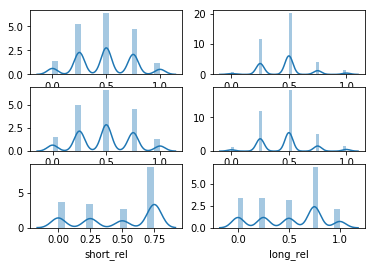

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=2)
sns.distplot(df_disc.short_noise, ax=axs[0][0])
sns.distplot(df_disc.long_noise, ax=axs[0][1])
sns.distplot(df_disc.short_gradient, ax=axs[1][0])
sns.distplot(df_disc.long_gradient, ax=axs[1][1])
sns.distplot(df_disc.short_rel, ax=axs[2][0])
sns.distplot(df_disc.long_rel, ax=axs[2][1])

## Montagem do Grafo

Pegando nós únicos e gerando ids para eles

In [9]:
model_nodes = df_disc.drop_duplicates()
model_nodes = model_nodes.assign(
    node_id= range(1, len(model_nodes) + 1)
).set_index('node_id')
model_nodes

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
node_id,,,,,,
1,0.75,1.00,1.00,1.00,0.50,0.75
2,0.25,1.00,0.75,1.00,0.25,0.75
3,0.50,1.00,0.75,1.00,0.50,0.75
4,1.00,1.00,1.00,1.00,0.75,0.75
5,1.00,1.00,1.00,1.00,0.75,1.00
...,...,...,...,...,...,...
445,0.50,0.50,0.50,0.25,0.25,0.25
446,0.50,0.50,0.25,0.25,0.25,0.25
447,0.25,0.25,0.75,0.25,0.50,0.25


Atribuindo linhas de _df_disc_ para seus nós

In [10]:
df_with_ids = df_disc.merge(model_nodes.reset_index(),
                    on='short_noise long_noise short_gradient long_gradient short_rel long_rel'.split(),
                    right_index=True)[['node_id']]
df_with_ids.head(5)

,node_id
day,
1993-10-22,1
1994-04-04,1
1994-04-14,1
1993-10-25,2
1994-04-18,2


In [11]:
# state_graph = pd.DataFrame(columns)
edges = df_with_ids[:-1].assign(
    leads_to = df_with_ids.shift(-1).dropna().astype(int)
)
edges
# adjacency_graph = edges.pivot_table(
#         index='node_id',
#         columns=['leads_to'], 
#         aggfunc=len)\
#     .fillna(0)

# adjacency_graph

,node_id,leads_to
day,,
1993-10-22,1,1
1994-04-04,1,1
1994-04-14,1,2
1993-10-25,2,2
1994-04-18,2,2
...,...,...
2016-01-03,449,449
2018-07-25,449,449
2018-07-26,449,449


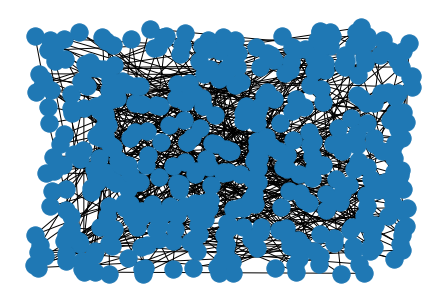

In [12]:
nx_graph = nx.convert_matrix.from_pandas_edgelist(edges, source='node_id', target='leads_to')
nx.draw_random(nx_graph)
plt.show()

### Visualização do grafo
![](./images/graph_1.png)

![](./images/graph_2.png)
